In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pysindy as ps
from scipy.integrate import solve_ivp
from scipy.ndimage import gaussian_filter1d
from scipy.integrate import cumtrapz

import os

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from pysindy.feature_library import FourierLibrary
from pysindy.feature_library import CustomLibrary
from pysindy.feature_library import PolynomialLibrary

from pysindy.optimizers import SR3
from pysindy.optimizers import ConstrainedSR3
#import sdeint

# Integrator keywords for solve_ivp
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

In [24]:
# # Set the directory path and filenames
# folder_path = 'C:/1. Power grid frequency data/'
# file_names = ['ES_PM01.csv', 'IS02.csv', 'IRL01.csv']

# # Load the CSV files into dataframes
# dataframes = []
# for file_name in file_names:
#     file_path = os.path.join(folder_path, file_name)
#     df = pd.read_csv(file_path, sep=';', 
#                      usecols=[0,1,2], names=['Time','f50','QI'],
#                      header=0)
#     df.iloc[:,1]=df.iloc[:,1]/1000+50
#     dataframes.append(df)

# Set the directory path and filenames
folder_path = 'C:/1. Power grid frequency data/'
file_names = ['ES_PM01.csv', 'IS02.csv', 'IRL01.csv']
#file_names = ['IS02.csv']
# Load the CSV files into dataframes
dataframes = []
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(file_path, sep=';', 
                     usecols=[0,1,2], names=['Time','f50','QI'],
                     header=0)
                     #header=0, index_col=0)
    df.iloc[:,1]=df.iloc[:,1]/1000+50
    #df.iloc[:,0]=df.iloc[:,0]/1000+50
    dataframes.append(df)


# # Only select quality QI=0
# flt_dataframes = []
# for df in dataframes:
#     flt_dfs = df[df['QI'] == 0].dropna()
#     flt_dataframes.append(flt_dfs)
    
# region_dict = {0: 'Balearic', 1: 'Iceland', 2: 'Ireland'}

# # Group the dataframes by region
# region_groups = [df.groupby(lambda x: region_dict[i]) for i, df in enumerate(flt_dataframes)]
# colors=('#66a61e', '#e6ab02','#a6761d')

In [25]:
bal = dataframes[0].copy()
bal.index = bal['Time']
bal.drop(columns=['Time'], inplace=True)
bal

interval_index = bal.index[0::3600]
bal.loc[bal['QI']!=0, 'f50'] = np.nan

freq = bal['f50']
n_steps = 3600
Y = freq.values.reshape((freq.shape[0]//n_steps, n_steps))
Y = pd.DataFrame(data=Y[:,:n_steps],
                    index = interval_index,
                    columns=np.arange(n_steps))
valid_ind = ~Y.isnull().any(axis=1)
Y = Y[valid_ind]
#Y

In [48]:
#grid = dataframes[0].copy()
#grid.index = grid['Time']
#grid.drop(columns=['Time'], inplace=True)

#grid = grid.loc['2021-11-05 09:00:00':] #Iceland 1
#grid = grid.loc['2021-11-04 17:00:00']

#interval_index = grid.index[0::3600]
#grid.loc[grid['QI']!=0, 'f50'] = np.nan

#freq = grid['f50']
#n_steps = 3600
#Y = freq.values.reshape((freq.shape[0]//n_steps, n_steps))
#Y = pd.DataFrame(data=Y[:,:n_steps],
#                    index = interval_index,
#                    columns=np.arange(n_steps))
#valid_ind = ~Y.isnull().any(axis=1)
#Y = Y[valid_ind]

In [26]:
omega = 2 * np.pi * (Y - 50)
omega_filtered = gaussian_filter1d(omega, sigma=60)

In [27]:
omega_filtered.shape

(2106, 3600)

In [28]:
def integrate_data(data, dt=1):
    """
    Manually integrate the data using a simple Euler integration method.

    Parameters:
    data (array): The input data to be integrated.
    dt (float): The time step for integration.

    Returns:
    integrated_data: The integrated data.
    """
    integrated_data = np.zeros_like(data)
    if data.ndim == 1:
        for i in range(1, len(data)):
            integrated_data[i] = integrated_data[i-1] + data[i] * dt
    elif data.ndim == 2:
        for i in range(1, data.shape[1]):
            integrated_data[:, i] = integrated_data[:, i-1] + data[:, i] * dt
    return integrated_data


In [29]:
theta = integrate_data(omega_filtered)
theta

array([[ 0.00000000e+00, -6.41414728e-01, -1.28280395e+00, ...,
        -1.84018017e+02, -1.84694132e+02, -1.85370242e+02],
       [ 0.00000000e+00, -5.91304414e-01, -1.18254749e+00, ...,
         3.57322764e+01,  3.62272773e+01,  3.67223599e+01],
       [ 0.00000000e+00,  7.73019629e-01,  1.54602764e+00, ...,
         3.14867863e+01,  3.15797708e+01,  3.16727515e+01],
       ...,
       [ 0.00000000e+00, -3.89494550e-01, -7.78992137e-01, ...,
         2.76981962e+02,  2.76829812e+02,  2.76677651e+02],
       [ 0.00000000e+00, -2.42801171e-01, -4.85622982e-01, ...,
         1.27025576e+02,  1.27214456e+02,  1.27403347e+02],
       [ 0.00000000e+00,  2.99553801e-01,  5.99109719e-01, ...,
         3.64448559e+02,  3.64015096e+02,  3.63581635e+02]])

In [30]:
def calculate_sindy_models(omega_filtered, region_name, n=2):
    sindy_models = []

    for row in omega_filtered:
        theta_row = integrate_data(row)
        stacked_data_row = np.column_stack((theta_row, row))
        t_train_row = np.arange(0, len(stacked_data_row), 1)
        linear_time_feature_row = t_train_row.reshape(-1, 1)
        x_train_augmented_row = np.hstack([stacked_data_row, linear_time_feature_row])
        
        feature_names_row = ["theta", "omega", "time"]
        polynomial_library_row = ps.PolynomialLibrary(degree=n)
        sparse_regression_optimizer_row = ps.STLSQ(threshold=1e-10, alpha=10**5, max_iter=10**8)
        
        model_row = ps.SINDy(feature_names=feature_names_row, 
                             feature_library=polynomial_library_row,
                             optimizer=sparse_regression_optimizer_row)
        
        model_row.fit(x_train_augmented_row, t=1)
        sindy_models.append(model_row)
        
        #print(f"Model for {region_name} - Row {len(sindy_models)}:")
        #model_row.print(precision=7)

    total_models = len(sindy_models)
    print(f"Total number of SINDy models generated: {total_models}")
        
    return sindy_models

In [33]:
sindy_models_n2 = calculate_sindy_models(omega_filtered, 'Balearic', n=2)
# Function to calculate RMSE
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Define simulation parameters
s = 10
delta_t = 1 / s
default_simulation_steps = 3600*s 
divergence_limit = 3600*s  # Limit for diverging rows
error_simulation_limit = 3600*s  # Limit for rows with numerical errors
divergence_threshold = 100  # Threshold to detect divergence

rmse_values_n2 = []  # Store RMSE values for each row
om_n2 = []
unstable_n2 = 0
# Suppress RuntimeWarning to be caught as an exception
np.seterr(over='raise', divide='raise', invalid='raise')


for idx in range(len(sindy_models_n2)):
    th = np.zeros(default_simulation_steps)
    om = np.zeros(default_simulation_steps)
    t = np.arange(0,default_simulation_steps//s,delta_t) 

    # Set initial conditions
    th[0], om[0] = integrate_data(omega_filtered[idx])[0], omega_filtered[idx][0]

    # Extract coefficients from the SINDy model
    coefficients = sindy_models_n2[idx].coefficients()

    limited_simulation = False  # Flag to indicate whether to limit the simulation

    try:
        for i in range(default_simulation_steps - 1):
            th[i + 1] = th[i] + delta_t * (coefficients[0, 0] + coefficients[0, 1] * th[i] + coefficients[0, 2] * om[i] + coefficients[0, 3] * t[i] +
                                       coefficients[0, 4] * th[i]**2 + coefficients[0, 5] * th[i] * om[i] + coefficients[0, 6] * th[i] * t[i] +
                                       coefficients[0, 7] * om[i]**2 + coefficients[0, 8] * om[i] * t[i] + coefficients[0, 9] * t[i]**2)
            om[i + 1] = om[i] + delta_t * (coefficients[1, 0] + coefficients[1, 1] * th[i] + coefficients[1, 2] * om[i] + coefficients[1, 3] * t[i] +
                                       coefficients[1, 4] * th[i]**2 + coefficients[1, 5] * th[i] * om[i] + coefficients[1, 6] * th[i] * t[i] +
                                       coefficients[1, 7] * om[i]**2 + coefficients[1, 8] * om[i] * t[i] + coefficients[1, 9] * t[i]**2) 
            
            # Check for divergence and limit simulation if detected
            if (np.abs(om[i + 1]) > divergence_threshold) and not limited_simulation:
                limited_simulation = True
                unstable_n2 += 1
                simulation_end = min(i + 2, 3600*s)  # Ensure we don't exceed the bounds
                print(f"Row {idx} limited to first {simulation_end} points due to divergence.")
                break  # Exit the current for-loop

    except (FloatingPointError, OverflowError, RuntimeWarning) as e:
        print(f'Row {idx} encountered an error: {e}. Limiting to first {error_simulation_limit} data points.')
        limited_simulation = True
        simulation_end = 3600*s

    if limited_simulation:
        # If simulation is limited, use only the relevant portion of om
        om_used_for_rmse = om[:simulation_end]
    else:
        # Otherwise, use the full simulation data
        om_used_for_rmse = om

    om_n2.append(om_used_for_rmse)  # Store the om array (either full or limited)
    if limited_simulation == False:       
        # Calculate RMSE using the appropriate portion of omega_filtered
        omega_filtered_segment = omega_filtered[idx][:len(om_used_for_rmse)//s]
        rmse = calculate_rmse(omega_filtered_segment, om_used_for_rmse[::s])
        rmse_values_n2.append(rmse)

# After the loop
print("RMSE values:", rmse_values_n2)
share_of_unstable_intervals_n2 = unstable_n2 / len(sindy_models_n2)
print("Share of unstable intervals:", share_of_unstable_intervals_n2)


Total number of SINDy models generated: 2106
Row 5 limited to first 6385 points due to divergence.
Row 8 limited to first 9382 points due to divergence.
Row 13 limited to first 24214 points due to divergence.
Row 20 limited to first 12079 points due to divergence.
Row 30 limited to first 32137 points due to divergence.
Row 39 limited to first 35377 points due to divergence.
Row 41 limited to first 34007 points due to divergence.
Row 48 limited to first 30329 points due to divergence.
Row 51 limited to first 18875 points due to divergence.
Row 52 limited to first 14749 points due to divergence.
Row 54 limited to first 34454 points due to divergence.
Row 56 limited to first 28809 points due to divergence.
Row 63 limited to first 31882 points due to divergence.
Row 65 limited to first 34220 points due to divergence.
Row 67 limited to first 12125 points due to divergence.
Row 69 limited to first 12389 points due to divergence.
Row 70 limited to first 4335 points due to divergence.
Row 71 l

In [34]:
np.mean(rmse_values_n2)

0.29182772450700817

In [91]:
sindy_models_n2[1].get_feature_names()

['1',
 'theta',
 'omega',
 'time',
 'theta^2',
 'theta omega',
 'theta time',
 'omega^2',
 'omega time',
 'time^2']

In [36]:
sindy_models_n3 = calculate_sindy_models(omega_filtered, 'Balearic', n=3)

Total number of SINDy models generated: 2106


In [37]:
names3 = sindy_models_n3[1].get_feature_names()

In [38]:
for i, name in enumerate(names3):
    print(f"{i}: {name}")

0: 1
1: theta
2: omega
3: time
4: theta^2
5: theta omega
6: theta time
7: omega^2
8: omega time
9: time^2
10: theta^3
11: theta^2 omega
12: theta^2 time
13: theta omega^2
14: theta omega time
15: theta time^2
16: omega^3
17: omega^2 time
18: omega time^2
19: time^3


In [39]:
sindy_models_n3 = calculate_sindy_models(omega_filtered, 'Balearic', n=3)
# Function to calculate RMSE
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Define simulation parameters
s = 10
delta_t = 1 / s
default_simulation_steps = 3600*s 
divergence_limit = 3600*s  # Limit for diverging rows
error_simulation_limit = 3600*s  # Limit for rows with numerical errors
divergence_threshold = 100  # Threshold to detect divergence

# # Define simulation parameters
# s = 1
# delta_t = 1 / s
# default_simulation_steps = 3600
# divergence_limit = 3600  # Limit for diverging rows
# error_simulation_limit = 3600  # Limit for rows with numerical errors
# divergence_threshold = 100  # Threshold to detect divergence

rmse_values_n3 = []  # Store RMSE values for each row
om_n3 = []
unstable = 0

# Suppress RuntimeWarning to be caught as an exception
np.seterr(over='raise', divide='raise', invalid='raise')


for idx in range(len(sindy_models_n3)):
    th = np.zeros(default_simulation_steps)
    om = np.zeros(default_simulation_steps)
    t = np.arange(0,default_simulation_steps//s,delta_t) 
    # Set initial conditions
    th[0], om[0] = integrate_data(omega_filtered[idx])[0], omega_filtered[idx][0]

    # Extract coefficients from the SINDy model
    coefficients = sindy_models_n3[idx].coefficients()

    limited_simulation = False  # Flag to indicate whether to limit the simulation

    try:
        for i in range(default_simulation_steps - 1):
            th[i + 1] = th[i] + delta_t * (coefficients[0, 0] + coefficients[0, 1] * th[i] + coefficients[0, 2] * om[i] + coefficients[0, 3] * t[i] +
                                       coefficients[0, 4] * th[i]**2 + coefficients[0, 5] * th[i] * om[i] + coefficients[0, 6] * th[i] * t[i] +
                                       coefficients[0, 7] * om[i]**2 + coefficients[0, 8] * om[i] * t[i] + coefficients[0, 9] * t[i]**2 +
                                       coefficients[0, 10] * th[i]**3 + coefficients[0, 11] * th[i]**2 * om[i] + coefficients[0, 12] * th[i]**2 * t[i] +
                                       coefficients[0, 13] * th[i] * om[i]**2 + coefficients[0, 14] * th[i] * om[i] * t[i] + 
                                       coefficients[0, 15] * th[i] * t[i]**2 + 
                                       coefficients[0, 16] * om[i]**3 + coefficients[0, 17] * om[i] **2 * t[i] + 
                                       coefficients[0, 18] * om[i] * t[i]**2 + coefficients[0, 19] * t[i]**3)
            
            om[i + 1] = om[i] + delta_t * (coefficients[1, 0] + coefficients[1, 1] * th[i] + coefficients[1, 2] * om[i] + coefficients[1, 3] * t[i] +
                                       coefficients[1, 4] * th[i]**2 + coefficients[1, 5] * th[i] * om[i] + coefficients[1, 6] * th[i] * t[i] +
                                       coefficients[1, 7] * om[i]**2 + coefficients[1, 8] * om[i] * t[i] + coefficients[1, 9] * t[i]**2 +
                                       coefficients[1, 10] * th[i]**3 + coefficients[1, 11] * th[i]**2 * om[i] + coefficients[1, 12] * th[i]**2 * t[i] +
                                       coefficients[1, 13] * th[i] * om[i]**2 + coefficients[1, 14] * th[i] * om[i] * t[i] + 
                                       coefficients[1, 15] * th[i] * t[i]**2 + 
                                       coefficients[1, 16] * om[i]**3 + coefficients[1, 17] * om[i] **2 * t[i] + 
                                       coefficients[1, 18] * om[i] * t[i]**2 + coefficients[1, 19] * t[i]**3)  
            
            # Check for divergence and limit simulation if detected
            if (np.abs(om[i + 1]) > divergence_threshold) and not limited_simulation:
                limited_simulation = True
                unstable += 1
                simulation_end = min(i + 2, 3600*s)  # Ensure we don't exceed the bounds
                print(f"Row {idx} limited to first {simulation_end} points due to divergence.")
                break  # Exit the current for-loop

    except (FloatingPointError, OverflowError, RuntimeWarning) as e:
        print(f'Row {idx} encountered an error: {e}. Limiting to first {error_simulation_limit} data points.')
        limited_simulation = True
        simulation_end = 3600*s

    if limited_simulation:
        # If simulation is limited, use only the relevant portion of om
        om_used_for_rmse = om[:simulation_end]
    else:
        # Otherwise, use the full simulation data
        om_used_for_rmse = om

    om_n3.append(om_used_for_rmse)  # Store the om array (either full or limited)
    if limited_simulation == False:       
        # Calculate RMSE using the appropriate portion of omega_filtered
        omega_filtered_segment = omega_filtered[idx][:len(om_used_for_rmse)//s]
        rmse = calculate_rmse(omega_filtered_segment, om_used_for_rmse[::s])
        rmse_values_n3.append(rmse)

    # except (FloatingPointError, OverflowError, RuntimeWarning) as e:
    #     print(f"Row {idx} encountered an error: {e}. Limiting to first 600 data points.")
    #     limited_simulation = True
    #     simulation_end = 3600

    # if limited_simulation:
    #     # If simulation is limited, use only the relevant portion of om
    #     om_used_for_rmse = om[:simulation_end]
    # else:
    #     # Otherwise, use the full simulation data
    #     om_used_for_rmse = om

    # om_n3.append(om_used_for_rmse)  

    # # Calculate RMSE using the appropriate portion of omega_filtered
    # omega_filtered_segment = omega_filtered[idx][:len(om_used_for_rmse)]
    # rmse = calculate_rmse(omega_filtered_segment, om_used_for_rmse)
    # rmse_values_n3.append(rmse)

# After the loop
print("RMSE values:", rmse_values_n3)
share_of_unstable_intervals_n3 = unstable / len(sindy_models_n3)
print("Share of unstable intervals:", share_of_unstable_intervals_n3)


Total number of SINDy models generated: 2106
Row 0 limited to first 6960 points due to divergence.
Row 6 limited to first 701 points due to divergence.
Row 7 limited to first 10363 points due to divergence.
Row 11 limited to first 22329 points due to divergence.
Row 15 limited to first 7988 points due to divergence.
Row 18 limited to first 1718 points due to divergence.
Row 20 limited to first 30085 points due to divergence.
Row 23 limited to first 29605 points due to divergence.
Row 24 limited to first 22967 points due to divergence.
Row 28 limited to first 33545 points due to divergence.
Row 29 limited to first 9600 points due to divergence.
Row 30 limited to first 2224 points due to divergence.
Row 32 limited to first 1955 points due to divergence.
Row 35 limited to first 9201 points due to divergence.
Row 40 limited to first 23955 points due to divergence.
Row 41 limited to first 28256 points due to divergence.
Row 43 limited to first 5788 points due to divergence.
Row 44 limited t

In [40]:
np.mean(rmse_values_n2)

0.29182772450700817

In [41]:
np.mean(rmse_values_n3)

0.8866823499101361

In [42]:
share_of_unstable_intervals_n3

0.4116809116809117

In [60]:
def calculate_sindy_models_tri(omega_filtered, region_name, n=2, m=1):
    sindy_models = []

    for row in omega_filtered:
        theta_row = integrate_data(row)
        stacked_data_row = np.column_stack((theta_row, row))
        t_train_row = np.arange(0, len(stacked_data_row), 1)
        linear_time_feature_row = t_train_row.reshape(-1, 1)
        x_train_augmented_row = np.hstack([stacked_data_row, linear_time_feature_row])
        
        feature_names_row = ["theta", "omega", "time"]
        # Combine polynomial features with Fourier series features
        # combined_library = ps.PolynomialLibrary(degree=n) + ps.FourierLibrary(n_frequencies=n)
        combined_library = ps.PolynomialLibrary(degree=n) + ps.FourierLibrary(n_frequencies=m)
        
        sparse_regression_optimizer_row = ps.STLSQ(threshold=1e-10, alpha=10**5, max_iter=10**8)
        
        model_row = ps.SINDy(feature_names=feature_names_row, 
                             feature_library=combined_library,
                             optimizer=sparse_regression_optimizer_row)
        
        model_row.fit(x_train_augmented_row, t=1)
        sindy_models.append(model_row)
        
        # Optional: Print model information
        # print(f"Model for {region_name} - Row {len(sindy_models)}:")
        # model_row.print(precision=7)

    total_models = len(sindy_models)
    print(f"Total number of SINDy models generated: {total_models}")
        
    return sindy_models


In [61]:
sindy_models_tri = calculate_sindy_models_tri(omega_filtered, 'Balearic', n=2, m=2)

Total number of SINDy models generated: 2106


In [62]:
sindy_models_tri[1].get_feature_names()

['1',
 'theta',
 'omega',
 'time',
 'theta^2',
 'theta omega',
 'theta time',
 'omega^2',
 'omega time',
 'time^2',
 'sin(1 theta)',
 'cos(1 theta)',
 'sin(1 omega)',
 'cos(1 omega)',
 'sin(1 time)',
 'cos(1 time)',
 'sin(2 theta)',
 'cos(2 theta)',
 'sin(2 omega)',
 'cos(2 omega)',
 'sin(2 time)',
 'cos(2 time)']

In [63]:
# Function to calculate RMSE
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# # Define simulation parameters
# s = 1
# delta_t = 1 / s
# default_simulation_steps = 3600
# divergence_limit = 3600  # Limit for diverging rows
# error_simulation_limit = 3600  # Limit for rows with numerical errors
# divergence_threshold = 100  # Threshold to detect divergence

# Define simulation parameters
s = 10
delta_t = 1 / s
default_simulation_steps = 3600*s 
divergence_limit = 3600*s  # Limit for diverging rows
error_simulation_limit = 3600*s  # Limit for rows with numerical errors
divergence_threshold = 100  # Threshold to detect divergence

rmse_values_tri = []  # Store RMSE values for each row
om_tri = []
unstable = 0
# Suppress RuntimeWarning to be caught as an exception
np.seterr(over='raise', divide='raise', invalid='raise')


for idx in range(len(sindy_models_tri)):#(len(sindy_models_tri)):
    th = np.zeros(default_simulation_steps)
    om = np.zeros(default_simulation_steps)
    t = np.arange(0,default_simulation_steps//s,delta_t) 

    # Set initial conditions
    th[0], om[0] = integrate_data(omega_filtered[idx])[0], omega_filtered[idx][0]

    # Extract coefficients from the SINDy model
    coefficients = sindy_models_tri[idx].coefficients()

    limited_simulation = False  # Flag to indicate whether to limit the simulation

    try:
        
        for i in range(default_simulation_steps - 1):
            th[i + 1] = th[i] + delta_t * (coefficients[0, 0] + coefficients[0, 1] * th[i] + coefficients[0, 2] * om[i] + coefficients[0, 3] * t[i] +
                                       coefficients[0, 4] * th[i]**2 + coefficients[0, 5] * th[i] * om[i] + coefficients[0, 6] * th[i] * t[i] +
                                       coefficients[0, 7] * om[i]**2 + coefficients[0, 8] * om[i] * t[i] + coefficients[0, 9] * t[i]**2 +
                                       coefficients[0, 10] * np.sin(th[i]) + coefficients[0, 11] * np.cos(th[i]) + 
                                       coefficients[0, 12] * np.sin(om[i]) + coefficients[0, 13] * np.cos(om[i]) + 
                                       coefficients[0, 14] * np.sin(t[i]) +  coefficients[0, 15] * np.cos(t[i]) + 
                                       coefficients[0, 16] * np.sin(2*th[i]) + coefficients[0, 17] * np.cos(2*th[i]) + 
                                       coefficients[0, 18] * np.sin(2*om[i]) + coefficients[0, 19] * np.cos(2*om[i]) + 
                                       coefficients[0, 20] * np.sin(2*t[i]) +  coefficients[0, 21] * np.cos(2*t[i]))
            
            om[i + 1] = om[i] + delta_t * (coefficients[1, 0] + coefficients[1, 1] * th[i] + coefficients[0, 2] * om[i] + coefficients[1, 3] * t[i] +
                                       coefficients[1, 4] * th[i]**2 + coefficients[1, 5] * th[i] * om[i] + coefficients[1, 6] * th[i] * t[i] +
                                       coefficients[1, 7] * om[i]**2 + coefficients[1, 8] * om[i] * t[i] + coefficients[1, 9] * t[i]**2 +
                                       coefficients[1, 10] * np.sin(th[i]) + coefficients[1, 11] * np.cos(th[i]) + 
                                       coefficients[1, 12] * np.sin(om[i]) + coefficients[1, 13] * np.cos(om[i]) + 
                                       coefficients[1, 14] * np.sin(t[i]) +  coefficients[1, 15] * np.cos(t[i]) + 
                                       coefficients[1, 16] * np.sin(2*th[i]) + coefficients[1, 17] * np.cos(2*th[i]) + 
                                       coefficients[1, 18] * np.sin(2*om[i]) + coefficients[1, 19] * np.cos(2*om[i]) + 
                                       coefficients[1, 20] * np.sin(2*t[i]) +  coefficients[1, 21] * np.cos(2*t[i]))  
            
            # Check for divergence and limit simulation if detected
            if (np.abs(om[i + 1]) > divergence_threshold) and not limited_simulation:
                limited_simulation = True
                unstable += 1
                simulation_end = min(i + 2, 3600*s)  # Ensure we don't exceed the bounds
                print(f"Row {idx} limited to first {simulation_end} points due to divergence.")
                break  # Exit the current for-loop
    except (FloatingPointError, OverflowError, RuntimeWarning) as e:
        print(f'Row {idx} encountered an error: {e}. Limiting to first {error_simulation_limit} data points.')
        limited_simulation = True
        simulation_end = 3600*s

    if limited_simulation:
        # If simulation is limited, use only the relevant portion of om
        om_used_for_rmse = om[:simulation_end]
    else:
        # Otherwise, use the full simulation data
        om_used_for_rmse = om

    om_n2.append(om_used_for_rmse)  # Store the om array (either full or limited)
    if limited_simulation == False:       
        # Calculate RMSE using the appropriate portion of omega_filtered
        omega_filtered_segment = omega_filtered[idx][:len(om_used_for_rmse)//s]
        rmse = calculate_rmse(omega_filtered_segment, om_used_for_rmse[::s])
        rmse_values_tri.append(rmse)

    # except (FloatingPointError, OverflowError, RuntimeWarning) as e:
    #     print(f"Row {idx} encountered an error: {e}. Limiting to first 600 data points.")
    #     limited_simulation = True
    #     simulation_end = 3600

    # if limited_simulation:
    #     # If simulation is limited, use only the relevant portion of om
    #     om_used_for_rmse = om[:simulation_end]
    # else:
    #     # Otherwise, use the full simulation data
    #     om_used_for_rmse = om

    # om_tri.append(om_used_for_rmse)  

    # # Calculate RMSE using the appropriate portion of omega_filtered
    # omega_filtered_segment = omega_filtered[idx][:len(om_used_for_rmse)]
    # rmse = calculate_rmse(omega_filtered_segment, om_used_for_rmse)
    # rmse_values_tri.append(rmse)

# After the loop
print("RMSE values:", rmse_values_tri)
share_of_unstable_intervals_tri = unstable / len(sindy_models_tri)
print("Share of unstable intervals:", share_of_unstable_intervals_tri)

Row 0 limited to first 20 points due to divergence.
Row 2 limited to first 25916 points due to divergence.
Row 3 limited to first 12 points due to divergence.
Row 4 limited to first 19 points due to divergence.
Row 6 limited to first 6987 points due to divergence.
Row 7 limited to first 17 points due to divergence.
Row 8 limited to first 27 points due to divergence.
Row 9 limited to first 7 points due to divergence.
Row 10 limited to first 6 points due to divergence.
Row 11 limited to first 8 points due to divergence.
Row 12 limited to first 3 points due to divergence.
Row 14 limited to first 16 points due to divergence.
Row 15 limited to first 11 points due to divergence.
Row 18 limited to first 9 points due to divergence.
Row 19 limited to first 17 points due to divergence.
Row 20 limited to first 7 points due to divergence.
Row 24 limited to first 12194 points due to divergence.
Row 26 limited to first 31717 points due to divergence.
Row 29 limited to first 17 points due to divergen

In [64]:
print(np.mean(rmse_values_tri))
print("Share of unstable intervals:", unstable / len(sindy_models_tri))

1.2325361215126431
Share of unstable intervals: 0.6609686609686609


In [55]:
sindy_models_tri_2_1 = calculate_sindy_models_tri(omega_filtered, 'Balearic', n=2, m=1)

Total number of SINDy models generated: 2106


In [56]:
sindy_models_tri_2_1[1].get_feature_names()

['1',
 'theta',
 'omega',
 'time',
 'theta^2',
 'theta omega',
 'theta time',
 'omega^2',
 'omega time',
 'time^2',
 'sin(1 theta)',
 'cos(1 theta)',
 'sin(1 omega)',
 'cos(1 omega)',
 'sin(1 time)',
 'cos(1 time)']

In [ ]:
# Function to calculate RMSE
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# # Define simulation parameters
# s = 1
# delta_t = 1 / s
# default_simulation_steps = 3600
# divergence_limit = 3600  # Limit for diverging rows
# error_simulation_limit = 3600  # Limit for rows with numerical errors
# divergence_threshold = 100  # Threshold to detect divergence

# Define simulation parameters
s = 10
delta_t = 1 / s
default_simulation_steps = 3600*s 
divergence_limit = 3600*s  # Limit for diverging rows
error_simulation_limit = 3600*s  # Limit for rows with numerical errors
divergence_threshold = 100  # Threshold to detect divergence

rmse_values_tri_2_1 = []  # Store RMSE values for each row
om_tri_2_1 = []
unstable = 0
# Suppress RuntimeWarning to be caught as an exception
np.seterr(over='raise', divide='raise', invalid='raise')


for idx in range(20):#(len(sindy_models_tri)):
    th = np.zeros(default_simulation_steps)
    om = np.zeros(default_simulation_steps)
    t = np.arange(0,default_simulation_steps//s,delta_t) 

    # Set initial conditions
    th[0], om[0] = integrate_data(omega_filtered[idx])[0], omega_filtered[idx][0]

    # Extract coefficients from the SINDy model
    coefficients = sindy_models_tri[idx].coefficients()

    limited_simulation = False  # Flag to indicate whether to limit the simulation

    try:
        
        for i in range(default_simulation_steps - 1):
            th[i + 1] = th[i] + delta_t * (coefficients[0, 0] + coefficients[0, 1] * th[i] + coefficients[0, 2] * om[i] + coefficients[0, 3] * t[i] +
                                       coefficients[0, 4] * th[i]**2 + coefficients[0, 5] * th[i] * om[i] + coefficients[0, 6] * th[i] * t[i] +
                                       coefficients[0, 7] * om[i]**2 + coefficients[0, 8] * om[i] * t[i] + coefficients[0, 9] * t[i]**2 +
                                       coefficients[0, 10] * np.sin(th[i]) + coefficients[0, 11] * np.cos(th[i]) + 
                                       coefficients[0, 12] * np.sin(om[i]) + coefficients[0, 13] * np.cos(om[i]) + 
                                       coefficients[0, 14] * np.sin(t[i]) +  coefficients[0, 15] * np.cos(t[i]) 
            
            om[i + 1] = om[i] + delta_t * (coefficients[1, 0] + coefficients[1, 1] * th[i] + coefficients[0, 2] * om[i] + coefficients[1, 3] * t[i] +
                                       coefficients[1, 4] * th[i]**2 + coefficients[1, 5] * th[i] * om[i] + coefficients[1, 6] * th[i] * t[i] +
                                       coefficients[1, 7] * om[i]**2 + coefficients[1, 8] * om[i] * t[i] + coefficients[1, 9] * t[i]**2 +
                                       coefficients[1, 10] * np.sin(th[i]) + coefficients[1, 11] * np.cos(th[i]) + 
                                       coefficients[1, 12] * np.sin(om[i]) + coefficients[1, 13] * np.cos(om[i]) + 
                                       coefficients[1, 14] * np.sin(t[i]) +  coefficients[1, 15] * np.cos(t[i]) 
            
            # Check for divergence and limit simulation if detected
            if (np.abs(om[i + 1]) > divergence_threshold) and not limited_simulation:
                limited_simulation = True
                unstable += 1
                simulation_end = min(i + 2, 3600*s)  # Ensure we don't exceed the bounds
                print(f"Row {idx} limited to first {simulation_end} points due to divergence.")
                break  # Exit the current for-loop
    except (FloatingPointError, OverflowError, RuntimeWarning) as e:
        print(f'Row {idx} encountered an error: {e}. Limiting to first {error_simulation_limit} data points.')
        limited_simulation = True
        simulation_end = 3600*s

    if limited_simulation:
        # If simulation is limited, use only the relevant portion of om
        om_used_for_rmse = om[:simulation_end]
    else:
        # Otherwise, use the full simulation data
        om_used_for_rmse = om

    om_n2.append(om_used_for_rmse)  # Store the om array (either full or limited)
    if limited_simulation == False:       
        # Calculate RMSE using the appropriate portion of omega_filtered
        omega_filtered_segment = omega_filtered[idx][:len(om_used_for_rmse)//s]
        rmse = calculate_rmse(omega_filtered_segment, om_used_for_rmse[::s])
        rmse_values_tri_2_1.append(rmse)

    # except (FloatingPointError, OverflowError, RuntimeWarning) as e:
    #     print(f"Row {idx} encountered an error: {e}. Limiting to first 600 data points.")
    #     limited_simulation = True
    #     simulation_end = 3600

    # if limited_simulation:
    #     # If simulation is limited, use only the relevant portion of om
    #     om_used_for_rmse = om[:simulation_end]
    # else:
    #     # Otherwise, use the full simulation data
    #     om_used_for_rmse = om

    # om_tri.append(om_used_for_rmse)  

    # # Calculate RMSE using the appropriate portion of omega_filtered
    # omega_filtered_segment = omega_filtered[idx][:len(om_used_for_rmse)]
    # rmse = calculate_rmse(omega_filtered_segment, om_used_for_rmse)
    # rmse_values_tri.append(rmse)

# After the loop
print("RMSE values:", rmse_values_tri_2_1)
share_of_unstable_intervals_tri = unstable / len(sindy_models_tri_2_1)
print("Share of unstable intervals:", share_of_unstable_intervals_tri)

In [40]:
np.save('rmse_values_tri.npy', rmse_values_tri)
np.save('rmse_values_n3.npy', rmse_values_n3)

In [42]:
np.save('share_of_unstable_intervals_tri.npy', share_of_unstable_intervals_tri)
np.save('share_of_unstable_intervals_n3.npy', share_of_unstable_intervals_n3)

In [44]:
rmse_values_n3 = np.load('rmse_values_n3.npy')

In [3]:
rmse_values_km = np.load('rmse_values_km.npy')
rmse_values_sindy_n2 = np.load('rmse_values_sindy.npy')
rmse_values_sindy_n3 = np.load('rmse_values_sindy_n3.npy')
#rmse_values_tri = np.load('rmse_values_tri_new.npy')

print(np.mean(rmse_values_sindy_n3))
print(np.mean(rmse_values_sindy_n2))
print(np.mean(rmse_values_km))

1.1585760990329672
519.460392514482
0.29207573840847556


In [20]:
# Filter values less than or equal to 1
rmse_values_sindy_n2_filtered = rmse_values_sindy_n2[rmse_values_sindy_n2 <= 0.8]
rmse_values_sindy_n3_filtered = rmse_values_sindy_n3[rmse_values_sindy_n3 <= 0.8]

# Calculate the mean
mean_rmse_sindy_n2 = np.mean(rmse_values_sindy_n2_filtered)
mean_rmse_sindy_n3 = np.mean(rmse_values_sindy_n3_filtered)

print("Mean RMSE for rmse_values_sindy_n2 (<= 1):", mean_rmse_sindy_n2)
print("Mean RMSE for rmse_values_sindy_n3 (<= 1):", mean_rmse_sindy_n3)

Mean RMSE for rmse_values_sindy_n2 (<= 1): 0.1646965599681843
Mean RMSE for rmse_values_sindy_n3 (<= 1): 0.18607633015986277


In [21]:
print(len(rmse_values_sindy_n2_filtered))
print(len(rmse_values_sindy_n3_filtered))

1330
1077


(array([ 4.,  1.,  3.,  8., 14., 27., 35., 45., 37., 51., 40., 47., 39.,
        49., 33., 38., 29., 37., 23., 28., 31., 21., 34., 30., 18., 19.,
        23., 29., 13., 20., 15., 26.,  9., 14., 22., 12., 10., 14.,  9.,
         7., 12.,  9.,  8., 13., 13.,  9.,  8., 11.,  6.,  9., 12.,  4.,
         9.,  3.,  7.,  8.,  7.,  4.,  8.,  3.,  8.,  6.,  5.,  6.,  6.,
         5.,  3.,  2.,  4.,  2.,  5.,  2.,  5.,  6.,  5.,  5.,  6.,  2.,
         4.,  1.,  3.,  6.,  5.,  2.,  3.,  3.,  2.,  4.,  1.,  6.,  4.,
         1.,  0.,  1.,  1.,  1.,  1.,  2.,  3.,  1.,  3.,  1.,  1.,  4.,
         4.,  0.,  2.,  1.,  0.,  2.,  2.,  1.,  0.,  2.,  1.,  0.,  1.,
         1.,  2.,  3.,  1.,  2.,  3.,  0.,  1.,  2.,  0.,  1.,  2.,  3.,
         1.,  1.,  3.,  2.,  0.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,  2.,
         0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  2.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         2.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.

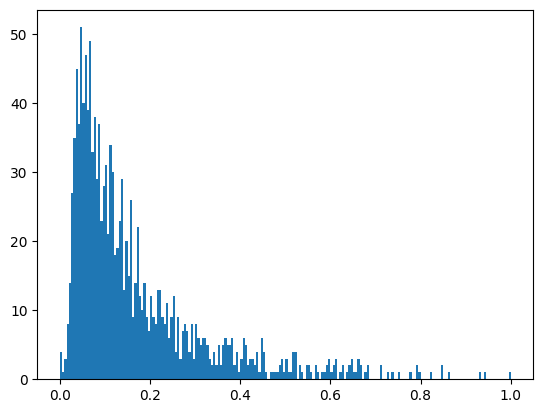

In [14]:
plt.hist(rmse_values_sindy_n2, bins=200, range=(0,1))

(array([ 1.,  0.,  5., 13., 15., 26., 35., 27., 35., 30., 22., 28., 29.,
        25., 31., 27., 21., 25., 20., 27., 21., 17., 18., 12., 18., 16.,
        15., 14., 15., 16., 17., 15., 11.,  8.,  7., 17., 14.,  9.,  9.,
        11., 11., 11.,  8.,  9., 12., 14.,  6.,  8.,  7., 11.,  5.,  6.,
         3.,  7.,  4.,  4.,  3.,  4.,  7.,  6.,  3.,  5.,  5.,  4.,  6.,
         2.,  1.,  2.,  5.,  9.,  2.,  5.,  4.,  2.,  5.,  3.,  4.,  4.,
         5.,  2.,  1.,  7.,  1.,  4.,  2.,  1.,  3.,  3.,  0.,  4.,  1.,
         2.,  1.,  3.,  3.,  7.,  6.,  6.,  1.,  0.,  2.,  1.,  0.,  3.,
         1.,  1.,  1.,  2.,  1.,  1.,  2.,  4.,  0.,  5.,  2.,  0.,  4.,
         2.,  2.,  1.,  1.,  2.,  3.,  0.,  1.,  1.,  1.,  1.,  2.,  1.,
         1.,  2.,  0.,  2.,  2.,  1.,  1.,  0.,  1.,  0.,  0.,  2.,  0.,
         1.,  1.,  1.,  3.,  0.,  1.,  0.,  1.,  4.,  3.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  2.,  1.,  3.,
         0.,  1.,  0.,  1.,  1.,  0.,  0.,  2.,  3.

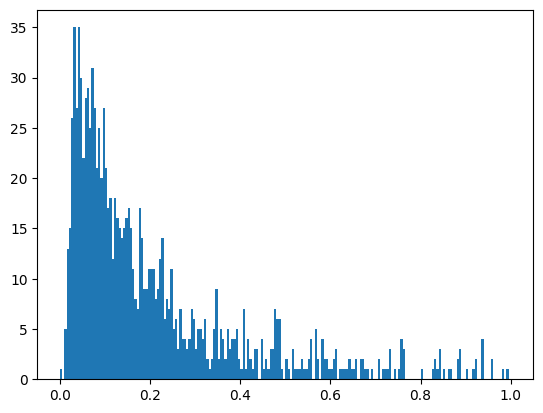

In [15]:
plt.hist(rmse_values_sindy_n3, bins=200, range=(0,1))

In [67]:
share_of_unstable_intervals_n2 = np.load('share_of_unstable_intervals_n2.npy')
share_of_unstable_intervals_n3 = np.load('share_of_unstable_intervals_n3.npy')
share_of_unstable_intervals_tri = np.load('share_of_unstable_intervals_tri.npy')

In [72]:
share_of_unstable_intervals_n2_new = np.load('share_of_unstable_intervals_n2_new.npy')
share_of_unstable_intervals_n3_new = np.load('share_of_unstable_intervals_n3_new.npy')
share_of_unstable_intervals_tri_new = np.load('share_of_unstable_intervals_tri_new.npy')

In [73]:
share_of_unstable_intervals_n2_new

array(0.36752137)

In [74]:
share_of_unstable_intervals_n3_new

array(0.46296296)

In [75]:
share_of_unstable_intervals_tri_new

array(0.50807217)

In [79]:
mean_rmse = np.mean(rmse_values_n2)
std_rmse = np.std(rmse_values_n2)

mean_rmse_n3 = np.mean(rmse_values_n3)
std_rmse_n3 = np.std(rmse_values_n3)

mean_rmse_tri = np.mean(rmse_values_tri)
std_rmse_tri = np.std(rmse_values_tri)

mean_rmse_ref = np.mean(rmse_values_km)
std_rmse_ref = np.std(rmse_values_km)


# Store the means and standard deviations in lists
means = [mean_rmse_ref, mean_rmse, mean_rmse_n3, mean_rmse_tri]
stds = [std_rmse_ref, std_rmse, std_rmse_n3, std_rmse_tri]
labels = ['1D-L-KM','Order 2', 'Order 3', 'Order 2 + Fourier']

In [80]:
means

[0.29207573840847556,
 0.18211206654614398,
 0.3829047550984066,
 1.7070008487626234]

In [81]:
stds

[0.1749621495595575,
 0.20516622382636981,
 0.8258250943876249,
 1.233968149061889]

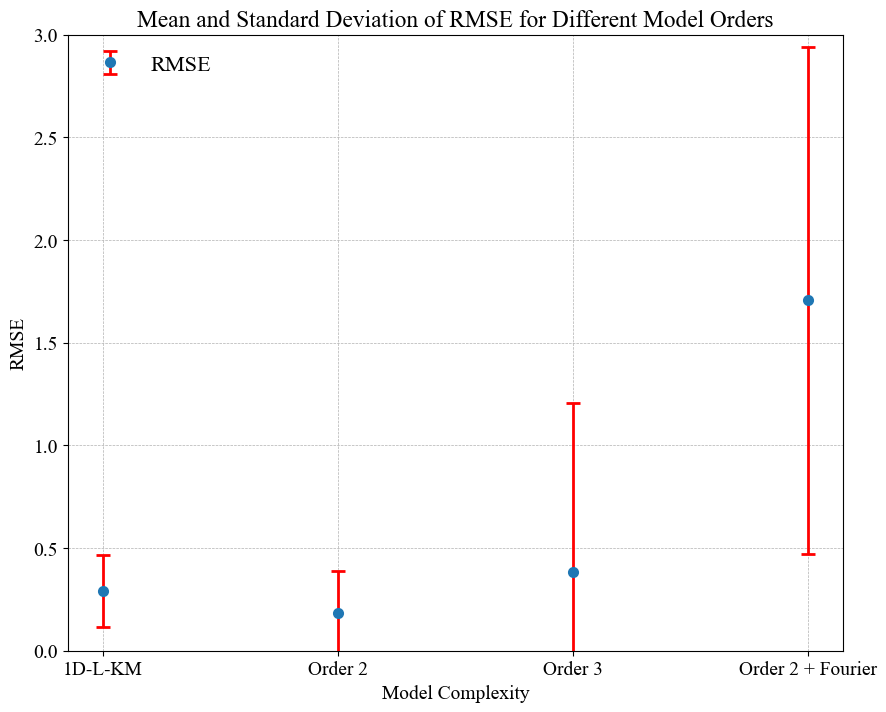

In [82]:
# Setting the font to New Times Roman
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14  # Adjusting the font size globally

# Creating the figure with a specified size
plt.figure(figsize=(10, 8))

# Plotting
plt.errorbar(labels, means, stds, linestyle='None', marker='o', capsize=5, ecolor='red', elinewidth=2, markeredgewidth=2)

# Labeling the axes and the title
plt.xlabel('Model Complexity')
plt.ylabel('RMSE')
plt.title('Mean and Standard Deviation of RMSE for Different Model Orders')

# Adjusting the y-axis limits
plt.ylim(0, 3)

# Adding a grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Customizing the legend
plt.legend(['RMSE'], fontsize=16, title_fontsize=16, frameon=False)

# Displaying the plot
plt.show()

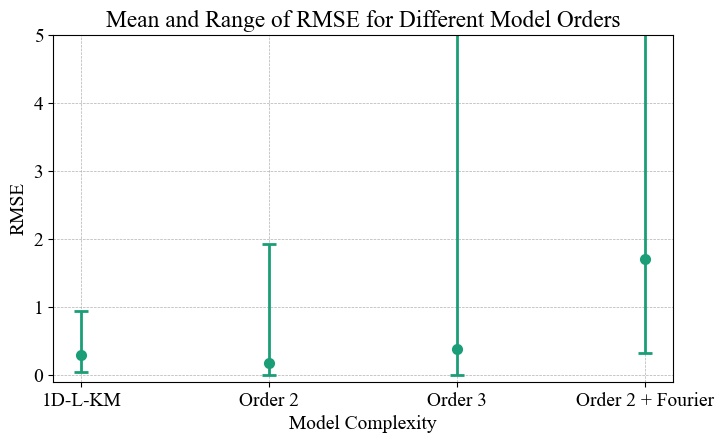

In [84]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming rmse_values_* are your data arrays for different model orders

# Calculate mean and standard deviation for each model
mean_rmse_ref = np.mean(rmse_values_km)
mean_rmse = np.mean(rmse_values_n2)
mean_rmse_n3 = np.mean(rmse_values_n3)
mean_rmse_tri = np.mean(rmse_values_tri)

# Calculate min and max for each model
min_rmse_ref = np.min(rmse_values_km)
min_rmse = np.min(rmse_values_n2)
min_rmse_n3 = np.min(rmse_values_n3)
min_rmse_tri = np.min(rmse_values_tri)

max_rmse_ref = np.max(rmse_values_km)
max_rmse = np.max(rmse_values_n2)
max_rmse_n3 = np.max(rmse_values_n3)
max_rmse_tri = np.max(rmse_values_tri)

# Store the means, mins, and maxs in lists
means = [mean_rmse_ref, mean_rmse, mean_rmse_n3, mean_rmse_tri]
mins = [min_rmse_ref, min_rmse, min_rmse_n3, min_rmse_tri]
maxs = [max_rmse_ref, max_rmse, max_rmse_n3, max_rmse_tri]

labels = ['1D-L-KM','Order 2', 'Order 3', 'Order 2 + Fourier'] 
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14  

# Creating the figure with a specified size
plt.figure(figsize=(8, 4.5))

# Plotting
plt.errorbar(labels, means, yerr=[[means[i] - mins[i] for i in range(len(means))], [maxs[i] - means[i] for i in range(len(means))]], 
             linestyle='None', marker='o', capsize=5, color='#1b9e77', ecolor='#1b9e77', elinewidth=2, markeredgewidth=2, markerfacecolor='#1b9e77')

# Labeling the axes and the title
plt.xlabel('Model Complexity')
plt.ylabel('RMSE')
plt.title('Mean and Range of RMSE for Different Model Orders')

# Adjusting the y-axis limits
plt.ylim(-0.1, 5)

# Adding a grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Customizing the legend
#plt.legend(['RMSE'], fontsize=16, title_fontsize=16, frameon=False)

plt.savefig('C:/4. Paper plots/figRMSE.pdf')
#plt.show()

